In [3]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 605.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 29.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.6 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 24.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

In [20]:
att=["cycle","current_load"]
dataset[["Soh"]]=dataset[["capacity"]]/2

In [21]:
Soh=dataset["capacity"]/dataset["capacity"][0]
time=dataset[["time"]]

In [22]:
# normalising data
dataset=dataset[["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load"]]
df_norm = (dataset-dataset.min())/(dataset.max()-dataset.min())
df_norm["time"]=time
df_norm["Soh"]=Soh

In [23]:
att_=["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load","time"]

In [24]:
X = df_norm[att]
Y = df_norm[["Soh"]]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [26]:
#sorting data wrt to index
X_test = X_test.sort_index(axis=0)
X_train= X_train.sort_index(axis=0)
y_train= y_train.sort_index(axis=0)
y_test = y_test.sort_index(axis=0)

In [27]:
#define lstm model we have 4 input variable so 3 layers
#model.add(LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True,input_shape=(X_train.shape[1],1)))
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.25))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 2, 128)            66560     
                                                                 
 dropout_3 (Dropout)         (None, 2, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 2, 64)             49408     
                                                                 
 dropout_4 (Dropout)         (None, 2, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [29]:
model.fit(X_train, y_train, epochs=200,batch_size=32, verbose=1,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200


880/880 [==============================] - 10s 7ms/step - loss: 0.0246 - val_loss: 4.0752e-04
Epoch 2/200
880/880 [==============================] - 5s 6ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 3/200
880/880 [==============================] - 5s 6ms/step - loss: 0.0033 - val_loss: 0.0056
Epoch 4/200
880/880 [==============================] - 6s 7ms/step - loss: 0.0025 - val_loss: 5.2506e-04
Epoch 5/200
880/880 [==============================] - 5s 6ms/step - loss: 0.0017 - val_loss: 1.3668e-04
Epoch 6/200
880/880 [==============================] - 6s 7ms/step - loss: 0.0011 - val_loss: 1.7796e-04
Epoch 7/200
880/880 [==============================] - 5s 6ms/step - loss: 6.3039e-04 - val_loss: 6.5630e-05
Epoch 8/200
880/880 [==============================] - 6s 7ms/step - loss: 3.5954e-04 - val_loss: 1.5496e-04
Epoch 9/200
880/880 [==============================] - 6s 6ms/step - loss: 2.2458e-04 - val_loss: 2.4049e-04
Epoch 10/200
880/880 [==============================] - 6s 7ms

In [30]:
y_pred_1 = model.predict(X_test, verbose=1)

472/472 [==============================] - 2s 2ms/step


In [31]:
y_pred_1

array([[0.9874536 ],
       [0.9807805 ],
       [0.9807805 ],
       ...,
       [0.69372904],
       [0.69372904],
       [0.69372904]], dtype=float32)

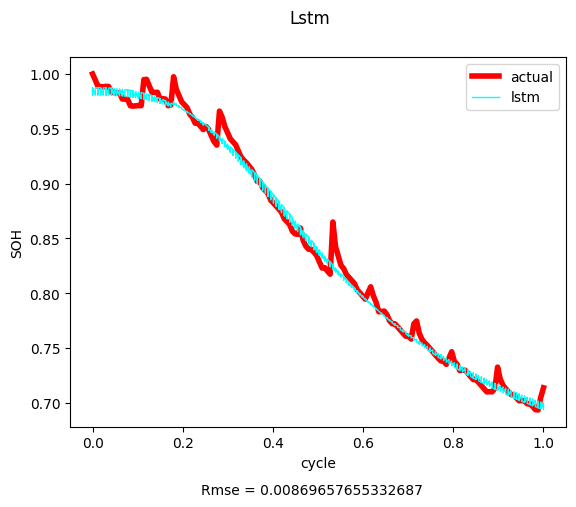

0.00869657655332687


In [32]:
plt.plot(X_test["cycle"],y_test,color='red',label='actual',linewidth=4)
plt.plot(X_test["cycle"],y_pred_1,color='cyan',label="lstm",linewidth=1)
plt.xlabel("cycle")
plt.ylabel("SOH")
rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))
plt.figtext(0.33, -0.03, rmse, fontsize=10)
plt.legend(loc="upper right")
plt.suptitle("Lstm")
plt.show()
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))

In [ ]:
0.0031518049884046912